In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
umap_prop = 1.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 'full' # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_1.0_1024_full____2020_08_09_12_15_54_108271_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [10]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [16]:
weight_decay = 1e-4
# https://github.com/RaptorMai/Cifar10-CNN-Keras/blob/master/Cifar_better.ipynb
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=dims))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Dense(512))
model.add(Dropout(0.9))
model.add(Dense(512))
model.add(Dropout(0.9))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

#model.summary()

In [17]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)       

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=20, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.2)

In [24]:
model.compile(tf.keras.optimizers.Adam(1e-4), loss = tf.keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [25]:
history = model.fit(
    X_labeled,
    Y_labeled,
    batch_size=batch_size,
    epochs=100,
    validation_data=(X_valid, Y_valid),
    callbacks = [early_stopping]
)

Epoch 1/100
313/313 [==============================] - 3s 10ms/step - loss: 1.7697 - accuracy: 0.5265 - val_loss: 1.4374 - val_accuracy: 0.5823
Epoch 2/100
313/313 [==============================] - 3s 9ms/step - loss: 1.7781 - accuracy: 0.5311 - val_loss: 1.2135 - val_accuracy: 0.5814
Epoch 3/100
313/313 [==============================] - 3s 9ms/step - loss: 1.7619 - accuracy: 0.5387 - val_loss: 1.3045 - val_accuracy: 0.5537
Epoch 4/100
313/313 [==============================] - 3s 9ms/step - loss: 1.6959 - accuracy: 0.5501 - val_loss: 1.2615 - val_accuracy: 0.5928
Epoch 5/100
313/313 [==============================] - 3s 9ms/step - loss: 1.6866 - accuracy: 0.5527 - val_loss: 1.4147 - val_accuracy: 0.5700
Epoch 6/100
313/313 [==============================] - 3s 9ms/step - loss: 1.6566 - accuracy: 0.5514 - val_loss: 1.2249 - val_accuracy: 0.6081
Epoch 7/100
313/313 [==============================] - 3s 9ms/step - loss: 1.6541 - accuracy: 0.5624 - val_loss: 1.2251 - val_accuracy: 0.591

313/313 [==============================] - 4s 14ms/step - loss: 0.8952 - accuracy: 0.7243 - val_loss: 0.8327 - val_accuracy: 0.7451
Epoch 58/100
313/313 [==============================] - 4s 11ms/step - loss: 0.9032 - accuracy: 0.7263 - val_loss: 0.8509 - val_accuracy: 0.7417
Epoch 59/100
313/313 [==============================] - 3s 10ms/step - loss: 0.8895 - accuracy: 0.7275 - val_loss: 0.8494 - val_accuracy: 0.7288
Epoch 60/100
313/313 [==============================] - 3s 9ms/step - loss: 0.8721 - accuracy: 0.7253 - val_loss: 0.8305 - val_accuracy: 0.7451
Epoch 61/100
313/313 [==============================] - 3s 9ms/step - loss: 0.8787 - accuracy: 0.7312 - val_loss: 0.8322 - val_accuracy: 0.7457
Epoch 62/100
313/313 [==============================] - 3s 9ms/step - loss: 0.8475 - accuracy: 0.7362 - val_loss: 0.8301 - val_accuracy: 0.7424
Epoch 63/100
313/313 [==============================] - 3s 9ms/step - loss: 0.8651 - accuracy: 0.7343 - val_loss: 0.8325 - val_accuracy: 0.7321
Ep

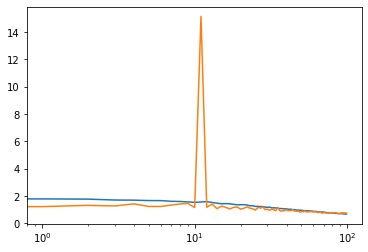

In [31]:
plt.semilogx(history.history['loss'])
plt.semilogx(history.history['val_loss'])

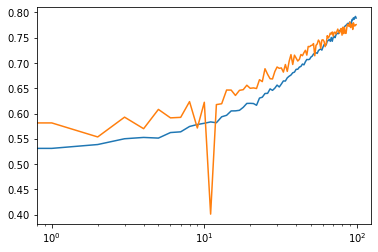

In [30]:
plt.semilogx(history.history['accuracy'])
plt.semilogx(history.history['val_accuracy'])